# Programming Challenge


Imports 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from typing import *
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, OneHotEncoder, StandardScaler
import graphviz 

# Preprocessing

load csv and apply the following changes
1. remove column 5
2. encode the labels as 0: Serpent, 1: Dragspel, 2: Nyckelharpa
3. replace N/A by ''
4. transform boolean column into TRUE: 1, and FALSE: 0

In [2]:
def label_encodings(label):
    if label == "Serpent":
        return 0
    elif label == "Dragspel":
        return 1
    else:
        return 2


# na_transform = lambda s: '' if s == 'N/A' else s
bool_transform = lambda b: 1 if b == 'TRUE' else 0

# data_types = [("y", "U11"), ("x1", np.float32), ("x2", np.float32), ("x3", np.float32), ("x4", np.float32), ("x5", np.float32), ("x6", "U17"), ("x7", np.float32), ("x8", np.float32), ("x9", np.float32), ("x10", np.float32), ("x11", np.float32), ("x12", np.float32), ("x13", np.float32)]
# Get all string features
labels, x6_raw = np.genfromtxt("/content/TrainOnMe-Clean.csv", delimiter=";", encoding="utf-8", dtype=None, skip_header=1, usecols=[0, 6], converters={0: label_encodings}, unpack=True)
# Get all float features
data_raw = np.loadtxt("/content/TrainOnMe-Clean.csv", delimiter=";", encoding="utf-8", skiprows=1, usecols=[1,2,3,4,7,8,9,10,11,12,13], converters = {11: bool_transform, 12: bool_transform})

In [ ]:
display(labels)
display(x6_raw)

### Normalize the float data

boolean data needs to be added back in


In [119]:
# data_normed = normalize(data_raw, axis=0) # rewrite the boolean columsn that get ruined by the normalization
scalar = StandardScaler().fit(data_raw)
data_normed = scalar.transform(data_raw)
data_normed[:, -3] = data_raw[:, -3]
data_normed[:, -2] = data_raw[:, -2]

In [ ]:
print(data_normed[:10])

### One-hot encoding of x6 categorial features

- first get the categories (including N/A)
- second encode them

In [120]:
categories = set(x6_raw)
# categories.remove('N/A')
categories = list(categories)

encoder = OneHotEncoder(handle_unknown='ignore', categories=[categories,])
# fit and transform x6 using the encoder
x6_encoded = encoder.fit_transform(x6_raw.reshape(-1, 1)) # reshape to make it column vector (comes as )
x6_encoded = x6_encoded.todense()

data = np.asarray(np.hstack((data_normed, x6_encoded)))

In [12]:
print(data.shape)
print(data[0])

(996, 18)
[-1.73007693  2.28816445  1.09602906  1.73084379 -1.45125524  1.69753505
  1.88882138 -1.42579039  1.          1.          1.73007204  0.
  0.          0.          0.          0.          1.          0.        ]


# Single execution of data split and classification

Split the data into test and training

In [81]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=0)
clf = DecisionTreeClassifier(criterion="entropy")
clf.fit(X=X_train, y=y_train)

DecisionTreeClassifier(criterion='entropy')

Pruning

Number of nodes in the last tree is: 1 with ccp_alpha: 0.171871986710457


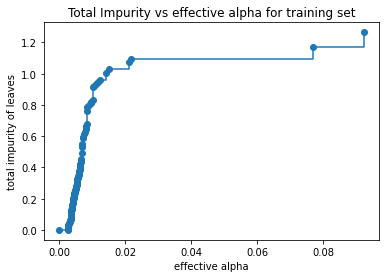

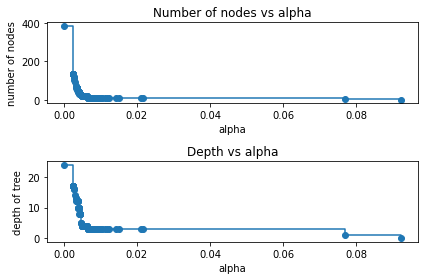

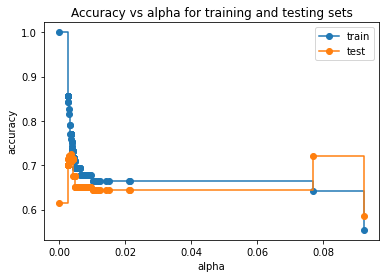

In [82]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

change the value of alpha to prune the tree: alpha=0.005

In [106]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=0)
clf = DecisionTreeClassifier(max_depth=6, criterion="entropy")
clf.fit(X=X_train, y=y_train)
prediction = clf.predict(X_test)

accuracy = 100*np.mean((prediction==y_test).astype(float))
print(accuracy)

72.5


In [84]:
# prova

dot_data = export_graphviz(clf, out_file=None,class_names=["Serpent","Dragspel","Nyckelharpa"],filled=True, rounded=True,special_characters=True) 
graph = graphviz.Source(dot_data) 
graph.render("pruned_tree")

'pruned_tree.pdf'

# Test Classifier

classification and testing steps put together in a loop

In [131]:
def test_classifier(data, labels, ntrials = 100): 
    means = np.zeros(ntrials,)
    for trial in range(ntrials):
        X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=0)

        # Train
        # clf = DecisionTreeClassifier(criterion="entropy", max_depth=6)
        # clf = GaussianNB()
        clf = RandomForestClassifier(n_estimators=20, criterion="entropy", max_depth=7)
        clf.fit(X=X_train, y=y_train)
        # Predict
        prediction = clf.predict(X_test)

        # Compute classification error
        if trial % 10 == 0:
            print("Trial:",trial,"Accuracy","%.3g" % (100*np.mean((prediction==y_test).astype(float))) )

        means[trial] = 100*np.mean((prediction==y_test).astype(float))

    print("Final mean classification accuracy ", "%.3g" % (np.mean(means)), "with standard deviation", "%.3g" % (np.std(means)))

Test Relevance of Features

In [ ]:
n_data, n_features = data.shape
for x in range(n_features):
  # sel = range(len(features) - x)
  print(f"Predictive power of feature f{x}:")
  test_classifier(data[:, x].reshape(-1, 1), labels, ntrials=10)


In [132]:
test_classifier(data, labels, ntrials=100)

Trial: 0 Accuracy 74
Trial: 10 Accuracy 73.5
Trial: 20 Accuracy 75.5
Trial: 30 Accuracy 76.5
Trial: 40 Accuracy 73.5
Trial: 50 Accuracy 74.5
Trial: 60 Accuracy 75
Trial: 70 Accuracy 76
Trial: 80 Accuracy 75.5
Trial: 90 Accuracy 74.5
Final mean classification accuracy  74.5 with standard deviation 1.22


In [ ]:
n_data, n_features = data.shape
for x in range(n_features):
  sel = list(range(n_features - x))
  sel = [abs(x-17) for x in sel]
  print(f"Predictive power of feature {sel}:")
  test_classifier(data[:, sel], labels, ntrials=30)

Predictive power of feature [17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]:
Trial: 0 Accuracy 75.5
Trial: 10 Accuracy 75.5
Trial: 20 Accuracy 75.5
Final mean classification accuracy  75.5 with standard deviation 0
Predictive power of feature [17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]:
Trial: 0 Accuracy 75.5
Trial: 10 Accuracy 75.5
Trial: 20 Accuracy 75.5
Final mean classification accuracy  75.5 with standard deviation 0
Predictive power of feature [17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2]:
Trial: 0 Accuracy 75.5
Trial: 10 Accuracy 75.5
Trial: 20 Accuracy 75.5
Final mean classification accuracy  75.5 with standard deviation 0
Predictive power of feature [17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3]:
Trial: 0 Accuracy 75
Trial: 10 Accuracy 75
Trial: 20 Accuracy 75
Final mean classification accuracy  75 with standard deviation 0
Predictive power of feature [17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4]:
Trial: 0 Accuracy 75
Trial

# Testing Results

- All Classifiers (Naive Bayes, Decision Tree, Forest) achieve around the same accuracy (68%). 

- Decision Tree with pruning will only use x9 and ignore other features.

- Featues x8,x9,x10 seem to have the highest prediction power.

- Increasing the test set size decreases the classifier performance -> Classifier still overfitts on data

From ChatGPT for later experiments

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder

# create a categorical feature matrix X
X = np.array(['A', 'B', 'C', 'C', 'A', None, None]).reshape(-1, 1)
# create a target variable y
#y = [0, 1, 1, 1, 1]

# instantiate an OneHotEncoder object
encoder = OneHotEncoder(handle_unknown='ignore', categories=[['A', 'B', 'C'],])

# fit and transform X using the encoder
X_encoded = encoder.fit_transform(X)
display(X_encoded.todense())

# instantiate a DecisionTreeClassifier object
#dt = DecisionTreeClassifier()

# fit the model on the encoded features and target variable
#dt.fit(X_encoded, y)

matrix([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])